In [1]:
import pandas as pd
import numpy as np
import datetime
import calendar
import matplotlib.pyplot as plt
import seaborn as sns

from func import *

In [2]:
ev_types = {'event_id':'int64',
            'ref_type':'category',
            'ref_hash':'int64',
            'application_id':'int64',
            'attributed':'bool',
            'device_countrycode':'category',
            'device_os_version':'float64',
            'device_brand':'float64',
            'device_model':'float64',
            'device_city':'float64',
            'session_user_agent':'float64',
            'trans_id':'category',
            'user_agent':'float64',
            'event_uuid':'object',
            'carrier':'float64',
            'kind':'float64',
            'device_os':'category',
            'wifi':'category',
            'connection_type':'category',
            'ip_address':'int64',
            'device_language':'float64'}

events = pd.read_csv('../../../datos_tp/events.csv', dtype = ev_types)


In [3]:
installs = pd.read_csv('../../../datos_tp/installs.csv')
installs.rename(columns={'created':'date'},inplace=True)
installs['date'] = pd.to_datetime(installs['date'], format = '%Y-%m-%d %H:%M:%S')
events['date'] = pd.to_datetime(events['date'], format = '%Y-%m-%d %H:%M:%S')
installs['ins'] = 1
events['ins'] = 0

In [4]:
concat_types = {
            'ref_type':'category',
            'ref_hash':'int64',
            'application_id':'int64',
            'attributed':'category',
            'device_countrycode':'category',
            #'device_os_version':'float64',
            #'device_brand':'float64',
            #'device_model':'float64',
            #'device_city':'float64',
            #'session_user_agent':'float64',
            'trans_id':'category',
            #'user_agent':'float64',
            'event_uuid':'object',
            #'carrier':'float64',
            #'click_hash':'float64',
            #'kind':'float64',
            'device_os':'category',
            'wifi':'category',
            'connection_type':'category',
            'ip_address':'int64',
            #'device_language':'float64',
            'implicit':'category'}

tot_events = pd.concat([installs,events])
tot_events = tot_events.astype(concat_types)
#tot_events.info()

C:\Users\Joaquin\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [5]:
tot_events.loc[(tot_events['ins'] == 1), 'event_id'] = 'install'
tot_events.sort_values(by=["ip_address", "date"], inplace = True)

In [28]:
#tot_events.head()

In [104]:
#PARA TRABAJAR SOLO CON LOS EVENTOS QUE SUCEDIERON MAS DE n VECES, DESCOMENTO ESTA CELDA
n=500
ev_count = tot_events.event_id.value_counts()
ev_count = ev_count.reset_index().rename(columns={'index':'event'})
ev_count = ev_count[ev_count['event_id'] > n]
tot_events = tot_events.loc[tot_events.event_id.isin(ev_count.event)]

In [57]:
#top10apps = tot_events.application_id.value_counts().head(10)
#top10apps = top10apps.reset_index().rename(columns={'index':'app','application_id':'repeats'})
top10apps


,app,repeats
0,66,325696
1,64,259084
2,145,252431
3,63,181555
4,103,137513
5,57,134498
6,121,123711
7,212,108489
8,113,82962
9,39,76448


In [93]:
#COMO VEO QUE EL FLUJO DE EVENTOS DEPENDE MUCHO DE EL APPLICATION ID
#EN ESTA CELDA FILTRO EL DATAFRAME POR APLICACION
#PARA TRABAJAR SOBRE UNA APLICACION EN PARTICULAR, DESCOMENTO ESTA CELDA

tot_events = tot_events.loc[tot_events.application_id == 103]
tot_events.event_id.value_counts()

161.0    49647
162.0    45053
1.0      40595
164.0     1702
166.0      500
165.0       14
36.0         2
Name: event_id, dtype: int64

In [105]:
tot_events.reset_index(inplace=True)
sess = generateSessions(tot_events)
tot_events['session'] = sess
tot_events[['ip_address','date','session']].head()
#521945665648320	ver este IP

,ip_address,date,session
0,5287755497790,2019-03-07 14:38:21.082,0.0
1,5287755497790,2019-03-07 14:39:00.166,0.0
2,87345868419849,2019-03-10 15:13:05.468,0.0
3,87345868419849,2019-03-10 15:13:06.619,0.0
4,87345868419849,2019-03-10 15:13:13.086,0.0


In [106]:
tot_events.groupby(['ip_address','session','application_id','event_id']).agg({'ins':'sum'}).reset_index().head()

,ip_address,session,application_id,event_id,ins
0,5287755497790,0.0,103,161,0
1,5287755497790,0.0,103,162,0
2,87345868419849,0.0,103,1,0
3,87345868419849,0.0,103,161,0
4,87345868419849,0.0,103,162,0


In [107]:
#ev_on_app = tot_events.groupby(['application_id','event_id']).agg({'event_id':'count'}).rename(columns={'event_id':'event_counts'}).unstack()
#ev_on_app.reset_index(inplace=True)

In [108]:
next_event = pd.DataFrame()
next_event['event'] = tot_events.event_id
next_event['session'] = tot_events.session
next_event['ip_address'] = tot_events.ip_address
next_event.index = next_event.index+1
next_event['next_sess'] = tot_events.session
next_event['next_ip'] = tot_events.ip_address
next_event.loc[(next_event.session != next_event.next_sess) | (next_event.ip_address != next_event.next_ip), 'next_event'] = -1
next_event.loc[(next_event.session == next_event.next_sess) & (next_event.ip_address == next_event.next_ip), 'next_event'] = tot_events.event_id

#LAS SIGUIENTES LINEAS SON SOLO PARA ARMAR MATRIZ DE EVENTOS, PARA EXPLORAR OTROS DATOS LAS COMENTO
#next_event = next_event[['event','next_event']]
#next_event.head(10)



In [109]:
nev_group = next_event.groupby(['event','next_event']).agg({'next_event':'count'})
#SI QUIERO EL INVERSO (LA CANTIDAD DE EVENTOS DEPENDIENDO DEL NEXT_EVENT) CAMBIO ACA ARRIBA ESOS CAMPOS, NO SOBRE NEV_GROUP
nev_group['next_event'] = np.log(nev_group['next_event'])

nev_group.head()

next_event
event next_event            
1.0   -1.0         10.659351
       1.0          8.706656
       22.0         8.563886
       23.0         0.000000
       27.0         0.000000

In [110]:
#PARA VERLA MEJOR TENGO QUE FILTRAR LOS EVENTOS UNICOS
nev_group = nev_group.unstack('event')
nev_group.columns = nev_group.columns.get_level_values(1)
nev_group.fillna(0, inplace=True)
nev_group

#SI DESCOMENTO VEO LA MATRIZ

event,1.0,20.0,21.0,22.0,23.0,24.0,25.0,27.0,30.0,31.0,...,378.0,440.0,441.0,450.0,452.0,513.0,653.0,695.0,698.0,install
next_event,,,,,,,,,,,,,,,,,,,,,
-1.0,10.659351,4.499810,6.350886,12.034531,6.609349,3.637586,4.127134,4.718499,3.806662,11.871844,...,4.369448,4.343805,8.722580,5.857933,7.687997,7.508787,2.079442,3.610918,3.761200,6.139885
1.0,8.706656,0.000000,1.386294,8.592857,1.609438,0.000000,0.000000,1.386294,0.693147,6.784457,...,0.000000,0.000000,3.332205,1.098612,0.000000,4.174387,0.693147,1.609438,0.000000,5.598422
20.0,0.000000,8.738255,5.361292,4.955827,7.019297,4.174387,4.060443,2.197225,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
21.0,0.000000,5.899897,9.774403,7.634337,8.473868,6.508769,6.434547,4.330733,0.000000,1.098612,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
22.0,8.563886,5.170484,7.051856,12.789293,7.636752,4.762174,5.347108,6.338594,5.375278,8.102586,...,0.000000,0.000000,4.718499,2.833213,0.000000,8.492900,5.459586,4.382027,0.000000,7.292337
23.0,0.000000,6.736967,8.729721,7.886457,10.038193,7.238497,7.136483,5.676754,0.693147,1.098612,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
24.0,0.000000,3.891820,5.501258,4.574711,7.556428,6.914731,2.564949,2.484907,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25.0,0.000000,4.219508,5.105945,4.852030,7.522400,3.258097,6.796824,1.098612,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
27.0,0.000000,2.708050,4.584967,6.876265,5.225747,3.332205,2.639057,7.711101,0.693147,1.098612,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.386294,2.197225,0.000000,0.000000,0.000000


Text(159.0, 0.5, 'evento siguiente')

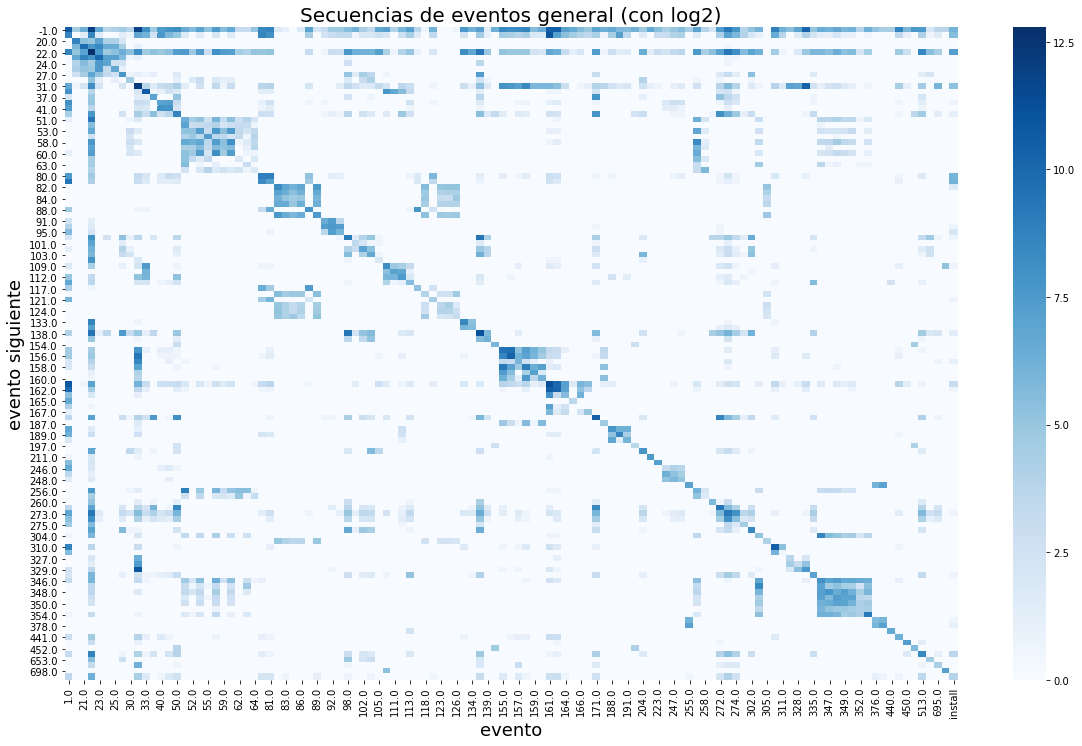

In [111]:
#CELDA PARA HEATMAP DE FLUJO DE EVENTOS PARA ALGUN APPLICATION_ID

fig = plt.figure(figsize=(20,12))
ax = fig.add_subplot(111)
ax.set_title('Secuencias de eventos general (con log2)',fontsize=20)
sns.heatmap(nev_group,ax=ax,cmap="Blues")
ax.set_xlabel('evento', fontsize=18)
ax.set_ylabel('evento siguiente', fontsize=18,)

In [58]:
#PISO LA MATRIZ O EL AGRUPAMIENTO
nev_group = nev_group.rename(columns = {'next_event':'repeats'}).reset_index()
nev_group.head()

event,next_event,1.0,36.0,161.0,162.0,164.0,165.0,166.0,167.0
0,-1.0,3454.0,0.0,28142.0,14656.0,520.0,700.0,282.0,150.0
1,1.0,201.0,0.0,26272.0,743.0,194.0,96.0,45.0,31.0
2,161.0,41578.0,1.0,79658.0,17893.0,997.0,0.0,370.0,243.0
3,162.0,220.0,0.0,30847.0,6535.0,584.0,0.0,187.0,30.0
4,164.0,7.0,0.0,2104.0,11.0,231.0,0.0,2.0,0.0


Text(0.5, 1.0, 'Wi-Fi activado en instalaciones')

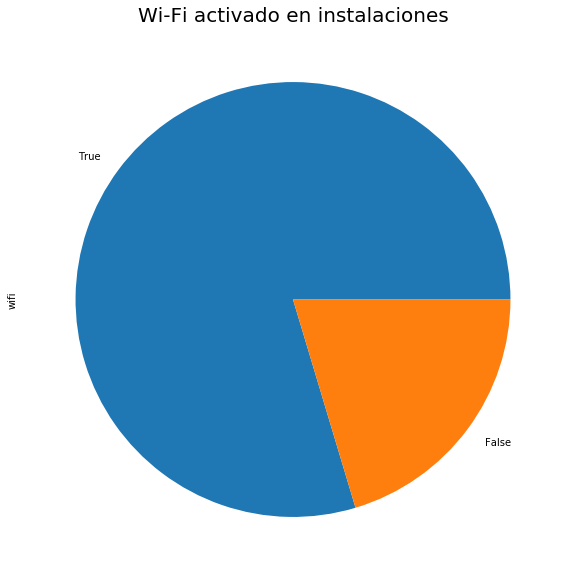

In [115]:
wifi_counts = installs.wifi.value_counts()

fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(111)
wifi_counts.plot.pie(ax=ax)
ax.set_title('Wi-Fi activado en instalaciones',fontsize=20)


In [31]:
#events['counts'] = 1
#app_city_group = events.groupby(['application_id','device_city']).agg({'counts':'sum'}).reset_index()
#app_city_group.head()
#app_city_group.groupby(['application_id','device_city']).agg({'counts':'max'})

In [31]:

#tot_events['repeats'] = 1
#top10apps_ev = tot_events.loc[tot_events.application_id.isin(top10apps.app)]

#ev_count = top10apps_ev.event_id.value_counts()
#ev_count = ev_count[ev_count > 2]
#ev_count = ev_count.reset_index().rename(columns={'index':'event','event_id':'repeats'})
#top10apps_ev = top10apps_ev.loc[(top10apps_ev.ins == 1)]

#top10apps_ev.groupby(['application_id']).agg({'repeats':'sum'})

,repeats
application_id,


In [78]:
installs.ref_hash.value_counts()

5208834946313176321    4
3272750442824629569    4
1999001885916451618    3
2457547163021424058    3
2515049144505739996    3
5376622639905210608    3
470581161921490835     3
2807966731127456435    3
394181128078904930     3
1332624341050561368    3
8209340170282049305    3
1826618012885478111    3
6207088909238189318    3
4603142710878547974    3
4587898421740190562    3
3429460795301152906    3
1838099903940931904    3
808602801225309575     3
2756309363004630634    3
5716316704073038128    3
1951826604052927528    3
5707101515634134793    3
3293250764324184935    3
6697381140026413622    2
1051816244049516468    2
2429923283539157643    2
8378288095655268347    2
4049391409413329307    2
1162390149017457197    2
8956666120381022264    2
                      ..
432026705480919604     1
868940215859934734     1
4424921869962083331    1
667593224187123722     1
826262859425189535     1
3807326297196549242    1
453115979634562298     1
2987878111541902309    1
3081130218041894318    1
